<a href="https://colab.research.google.com/github/AilingLiu/Growth_Analysis/blob/master/Monthly_Repeat_Customers_and_Revenue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm
import warnings
warnings.filterwarnings(action="ignore")

We will check how many customers are repeat customers, i.e. to place orders repeatedly within a month, and its contribution towards total sales revenue.

In [16]:
url='https://github.com/AilingLiu/Growth_Analysis/blob/master/Data/online_retail.csv?raw=true'
retail = pd.read_csv(url, encoding = 'unicode_escape')
retail['InvoiceDate']=pd.to_datetime(retail['InvoiceDate'])
retail['Payment'] = retail['Quantity'] * retail['UnitPrice']
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Payment
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [4]:
retail['Quantity'].describe()

count    541909.000000
mean          9.552250
std         218.081158
min      -80995.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quantity, dtype: float64

In [43]:
# we will first filter out the negative values from the dataset
df = retail.loc[(retail['Quantity']>0) & (retail['CustomerID'].notnull())]

# group by invoice
gb = df.groupby(['InvoiceNo', 'InvoiceDate']).agg({
    'Payment': 'sum',
    'CustomerID': 'max'
})
gb.reset_index(inplace=True)
gb.head()

,InvoiceNo,InvoiceDate,Payment,CustomerID
0,536365,2010-12-01 08:26:00,139.12,17850.0
1,536366,2010-12-01 08:28:00,22.20,17850.0
2,536367,2010-12-01 08:34:00,278.73,13047.0
3,536368,2010-12-01 08:34:00,70.05,13047.0
4,536369,2010-12-01 08:35:00,17.85,13047.0


In [91]:
# filter out to extract customers that have more than one invoice no within the same month
gb['InvoiceYM']=gb['InvoiceDate'].apply(lambda x: x.strftime('%Y%m'))
repeatCust = gb.groupby(['InvoiceYM', 'CustomerID']).filter(lambda sf: len(sf)>1)

repeatCustNum = repeatCust.groupby(['InvoiceYM'])['CustomerID'].nunique().to_frame('RepeatCust')
repeatCustNum['Total'] = gb.groupby(['InvoiceYM'])['CustomerID'].nunique()
repeatCustNum['Ratio'] = (repeatCustNum['RepeatCust']*100/repeatCustNum['Total']).round(2)
repeatCustNum

,RepeatCust,Total,Ratio
InvoiceYM,,,
201012,263,885,29.72
201101,153,741,20.65
201102,153,758,20.18
201103,203,974,20.84
201104,170,856,19.86
201105,281,1056,26.61
201106,220,991,22.20
201107,227,949,23.92
201108,198,935,21.18


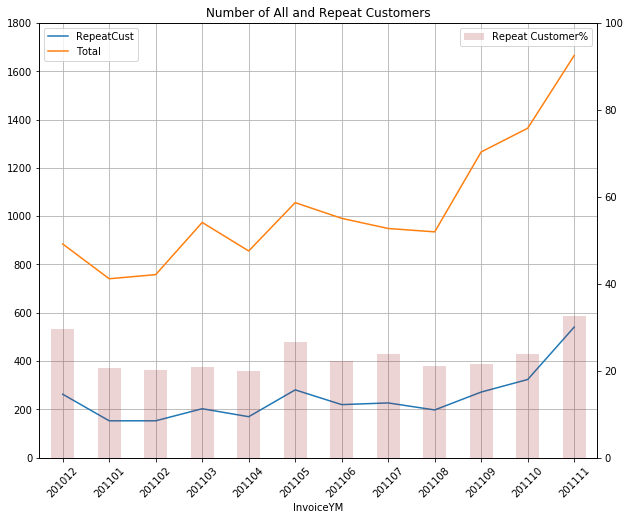

In [90]:
ax = repeatCustNum.iloc[:-1, [0, 1]].plot(grid=True, figsize=(10, 8), rot=45)
ax2 = repeatCustNum.iloc[:-1, -1].plot(kind='bar', secondary_y=True, grid=True, 
                                    figsize=(10, 8), color='brown', alpha=0.2, 
                                    rot=45)
ax2.set_ylim(0, 100)
ax.set_ylim(0, 1800)
ax2.legend(['Repeat Customer%'], loc='upper right')
ax.set_title('Number of All and Repeat Customers')
plt.show()

From Dec 2010 to Aug 2011, the total unique customer progressed steadly around 900, then it drastically increased from September and reached to almost double in November. Similar trends can be observed for Repeat Customer group, that it floated around 200 people before August, and climbed up in September then almost doubled in November. Repeat customers account for 20-30% on monthly average.

Now we can check how much revenue does this Repeat Customer group contribute.

In [92]:
rcRev = repeatCust.groupby(['InvoiceYM'])['Payment'].sum().to_frame('Rev_RepCust')
rcRev['Rev_Total'] = gb.groupby(['InvoiceYM'])['Payment'].sum()
rcRev['Rev_RepCust%'] = (rcRev['Rev_RepCust']*100 / rcRev['Rev_Total']).round(2)
rcRev

,Rev_RepCust,Rev_Total,Rev_RepCust%
InvoiceYM,,,
201012,359170.60,572713.890,62.71
201101,222124.00,569445.040,39.01
201102,191229.37,447137.350,42.77
201103,267390.48,595500.760,44.90
201104,195474.18,469200.361,41.66
201105,378197.04,678594.560,55.73
201106,376307.26,661213.690,56.91
201107,317475.00,600091.011,52.90
201108,317134.25,645343.900,49.14


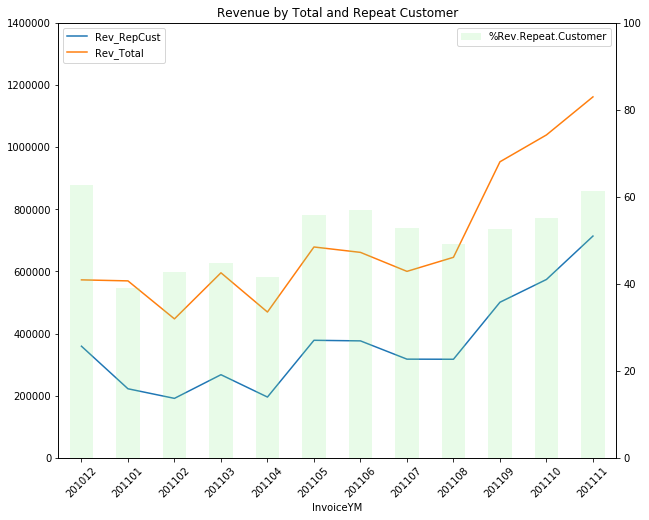

In [98]:
ax1 = rcRev.iloc[:-1, [0, 1]].plot(figsize=(10, 8), grid=True, rot=45, title='Revenue by Total and Repeat Customer')
ax2 = rcRev.iloc[:-1, 2].plot(kind='bar', color='lightgreen', rot=45, secondary_y=True, alpha=0.2)
ax2.set_ylim(0, 100)
ax1.set_ylim(0, 1400000)
ax1.legend(loc='upper left')
ax2.legend(['%Rev.Repeat.Customer'], loc='upper right')
plt.show()

The revenue followed the same fashion of the number of customers as above. However, the revenue ratio contributed by the repeat customer is about 40-60%, almost half of the revenue comes from the 20-30% of repeat customers. Customer retention is the linchpin of revenue driver.